# Dataset

In [1]:
import torch
import numpy as np
from torch.distributions import MultivariateNormal
torch.cuda.set_device(1)

class ToyDataset(object):
    def __init__(self, data_name):
        self.data_name = data_name
        self.rng = np.random.RandomState()

    def gen_batch(self, batch_size):
        return inf_train_gen(self.data_name, self.rng, batch_size)
    
    def log_prob(self, x):
        if self.data_name == '25gaussians':
            return log_prob_25gaussians(x)
        else:
            raise NotImplementedError
        
def inf_train_gen(data, rng=None, batch_size=200):
    if data == "25gaussians":
        scale = 4.
        centers = [(x/2, y/2) for x in range(-2,3) for y in range(-2,3)]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.2
            idx = rng.randint(25)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset
    else:
        raise NotImplementedError

def log_prob_25gaussians(x):
    scale = 4. / 1.414
    centers = [(x/2, y/2) for x in range(-2,3) for y in range(-2,3)]
    centers = [(scale * x, scale * y) for x, y in centers]

    conv = (1 / 25 / (1.414**2) * torch.eye(2)).to(x.device)
    gaussians = [MultivariateNormal(loc=torch.tensor(mu, device=x.device), covariance_matrix=conv) for mu in centers]

    log_probs = torch.stack([g.log_prob(x).unsqueeze(1) for g in gaussians], dim=1)
    log_probs = torch.logsumexp(log_probs, dim=1) - np.log(25.) #- np.log(2*np.pi) - 2*np.log(5) - 2*np.log(1.414)
    return log_probs

/data2/packages/anaconda3/envs/ebm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Models and Training Algorithms

In [2]:
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.autograd as autograd

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class ToyModel(nn.Module):
    def __init__(self, n_output=1):
        super().__init__()
        self.lin1 = nn.Linear(2, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 128)
        self.lin4 = nn.Linear(128, 128)
        self.lin5 = nn.Linear(128, n_output)

        self.act_func = nn.Softplus()

    def forward(self, x):
        x = self.act_func(self.lin1(x))
        x = self.act_func(self.lin2(x))
        x = self.act_func(self.lin3(x))
        x = self.act_func(self.lin4(x))
        x = self.lin5(x)
        return x
    
def energy_discrepancy(energy_net, samples, m_particles=4, t_noise=1.0, w_stable=1.0):
    device = samples.device

    browniani = torch.randn_like(samples).to(device) * t_noise
    brownianij = torch.randn(samples.size(0), m_particles, *samples.shape[1:]).to(device) * t_noise

    pert_data = samples.unsqueeze(1) + browniani.unsqueeze(1) + brownianij

    pos_energy = energy_net(samples)
    neg_energy = energy_net(pert_data.view(-1, *samples.shape[1:])).view(samples.size(0), -1)
    val = pos_energy - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)

    loss = val.logsumexp(dim=-1).mean()
    return loss

def score_matching(energy_net, samples):
    samples.requires_grad_(True)
    logp = -energy_net(samples).sum()
    grad1 = autograd.grad(logp, samples, create_graph=True)[0]
    loss1 = torch.norm(grad1, dim=-1) ** 2 / 2.
    loss2 = torch.zeros(samples.shape[0], device=samples.device)

    for i in range(samples.shape[1]):
        grad = autograd.grad(grad1[:, i].sum(), samples, create_graph=True, retain_graph=True)[0][:, i]
        loss2 += grad

    loss = loss1 + loss2

    return loss.mean()

def contrastive_divergence(energy_net, samples):
    num_steps = 10
    step_size = 0.01
    noise = torch.autograd.Variable(samples.clone(), requires_grad=True)
    for _ in range(num_steps):
        log_prob = -energy_net(noise)
        grad_y = torch.autograd.grad(log_prob.sum(), [noise], retain_graph=False)[0]
        noise.data += 0.5 * step_size * grad_y + np.sqrt(step_size) * torch.randn_like(noise)
    samples_neg = noise.detach()

    log_p_x_pos = -energy_net(samples)
    log_p_x_neg = -energy_net(samples_neg)

    loss_cd = torch.mean(log_p_x_neg - log_p_x_pos)
    loss_reg = torch.mean(log_p_x_pos**2 + log_p_x_neg**2)
    loss = loss_cd + .3 * loss_reg
    return loss

def mse_log_prob(dataset, energy_net):
    samples = dataset.gen_batch(5000)
    samples = torch.from_numpy(samples).float()

    if device is not None:
        samples = samples.to(device)

    log_ground_truth = dataset.log_prob(samples)

    log_prob = -energy_net(samples)
    logZ = torch.logsumexp(-energy_net(samples)-log_ground_truth, dim=(0)) - np.log(5000)
    log_prob_ebm = log_prob - logZ

    return torch.mean((log_prob_ebm - log_ground_truth) ** 2).cpu().item(), logZ.cpu().item()

def train(model, ema_model, optimizer, dataset, compute_mse=True, algo='ed', m_particles=4, t_noise=1.0, w_stable=1.0):
    mse_list = []
    for step in tqdm(range(50001)):
        samples = dataset.gen_batch(128)
        samples = torch.from_numpy(samples).float().to(device)
        
        if algo == 'ed':
            loss = energy_discrepancy(model, samples, m_particles, t_noise, w_stable)
        elif algo == 'sm':
            loss = score_matching(model, samples)
        elif algo == 'cd':
            loss = contrastive_divergence(model, samples)
        else:
            raise NotImplementedError
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                ema_p.mul_(0.999).add_(p, alpha=0.001)

        if compute_mse and step % 100 == 0:
            mse_list.append(mse_log_prob(dataset, ema_model)[0])

    if compute_mse:
        return np.array(mse_list)
    else:
        return

def visualize_energynet(energy_net, title, left_bound=-4., right_bound=4.):
    mesh = []
    grid_size = 100
    x = torch.linspace(left_bound, right_bound, grid_size)
    y = torch.linspace(left_bound, right_bound, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mesh = torch.stack([xx, yy], dim=-1).permute(1, 0, 2).reshape(-1, 2)
    mesh = mesh.to(device)

    prob = -energy_net(mesh).view(grid_size, grid_size)
    logZ = torch.logsumexp(prob, dim=(0, 1))
    prob = torch.exp(prob - logZ)

    plt.figure(figsize=(2,2))
    plt.imshow(np.flipud(prob.detach().cpu().numpy()), cmap='viridis', extent=[left_bound, right_bound, left_bound, right_bound])
    plt.title(title)
    plt.axis('off')
    plt.axis('square')
    plt.show()
    plt.close()

def plot_mse(mse_list, title):
    x = np.array([0, 100, 200, 300, 400, 500])
    plt.figure(figsize=(5,3.3), tight_layout=True)
    plt.plot(mse_list, linewidth=1.)
    plt.xticks(x, ['0', '10k', '20k', '30k', '40k', '50k'])
    plt.title(title, fontsize=12)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('MSE of log-density', fontsize=12)
    plt.ylim([-0.2, 5.2])
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    plt.close()


# Comparing ED with CD & SM

100%|██████████| 50001/50001 [13:17<00:00, 62.70it/s]


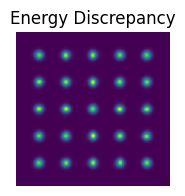

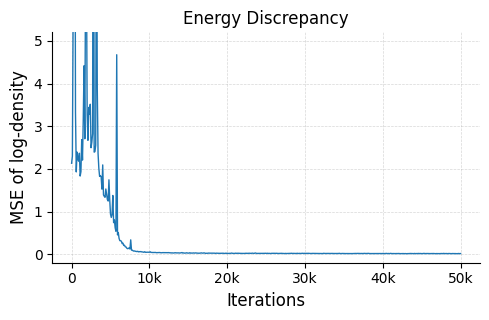

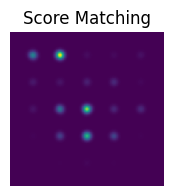

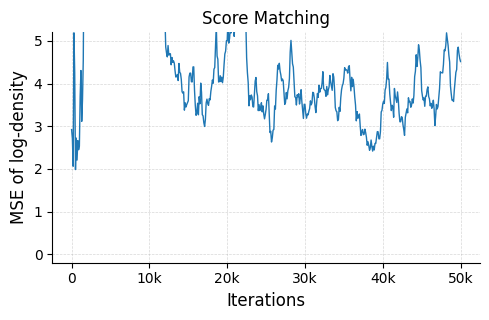

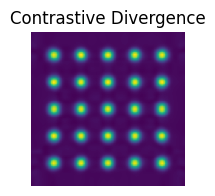

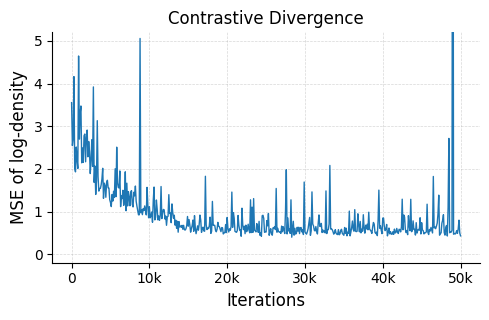

In [3]:
import torch.optim as optim

dataset = ToyDataset('25gaussians')

ebm_ed = ToyModel().to(device)
optimizer_ed = optim.Adam(ebm_ed.parameters(), lr=1e-3)
ema_ebm_ed = ToyModel(n_output=1).to(device)
ema_ebm_ed.load_state_dict(ebm_ed.state_dict())

ebm_sm = ToyModel().to(device)
optimizer_sm = optim.Adam(ebm_sm.parameters(), lr=1e-3)
ema_ebm_sm = ToyModel(n_output=1).to(device)
ema_ebm_sm.load_state_dict(ebm_sm.state_dict())

ebm_cd = ToyModel().to(device)
optimizer_cd = optim.Adam(ebm_cd.parameters(), lr=1e-3)
ema_ebm_cd = ToyModel(n_output=1).to(device)
ema_ebm_cd.load_state_dict(ebm_cd.state_dict())

mes_ed = train(ebm_ed, ema_ebm_ed, optimizer_ed, dataset, algo='ed', m_particles=4, t_noise=1.0, w_stable=1.0)
mes_sm = train(ebm_sm, ema_ebm_sm, optimizer_sm, dataset, algo='sm')
mes_cd = train(ebm_cd, ema_ebm_cd, optimizer_cd, dataset, algo='cd')

visualize_energynet(ema_ebm_ed, 'Energy Discrepancy')
plot_mse(mes_ed, 'Energy Discrepancy')
visualize_energynet(ema_ebm_sm, 'Score Matching')
plot_mse(mes_sm, 'Score Matching')
visualize_energynet(ema_ebm_cd, 'Contrastive Divergence')
plot_mse(mes_cd, 'Contrastive Divergence')

# Qualitatively Understanding the Effect of $t$ and $M$

$t=0.05, M=1, 32, 512, w=1$

100%|██████████| 50001/50001 [05:48<00:00, 143.67it/s]


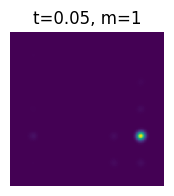

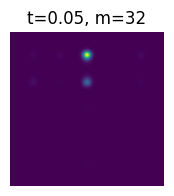

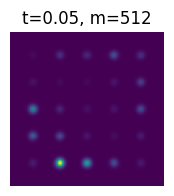

In [4]:
ebm1 = ToyModel().to(device)
optimizer_ebm1 = optim.Adam(ebm1.parameters(), lr=1e-3)
ema_ebm1 = ToyModel(n_output=1).to(device)
ema_ebm1.load_state_dict(ebm1.state_dict())

ebm2 = ToyModel().to(device)
optimizer_ebm2 = optim.Adam(ebm2.parameters(), lr=1e-3)
ema_ebm2 = ToyModel(n_output=1).to(device)
ema_ebm2.load_state_dict(ebm2.state_dict())

ebm3 = ToyModel().to(device)
optimizer_ebm3 = optim.Adam(ebm3.parameters(), lr=1e-3)
ema_ebm3 = ToyModel(n_output=1).to(device)
ema_ebm3.load_state_dict(ebm3.state_dict())

train(ebm1, ema_ebm1, optimizer_ebm1, dataset, compute_mse=False, algo='ed', m_particles=1, t_noise=0.05, w_stable=1.0)
train(ebm2, ema_ebm2, optimizer_ebm2, dataset, compute_mse=False, algo='ed', m_particles=32, t_noise=0.05, w_stable=1.0)
train(ebm3, ema_ebm3, optimizer_ebm3, dataset, compute_mse=False, algo='ed', m_particles=512, t_noise=0.05, w_stable=1.0)

visualize_energynet(ema_ebm1, 't=0.05, m=1')
visualize_energynet(ema_ebm2, 't=0.05, m=32')
visualize_energynet(ema_ebm3, 't=0.05, m=512')

$t=50, M=1, 32, 512, w=1$

100%|██████████| 50001/50001 [05:44<00:00, 144.97it/s]


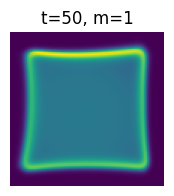

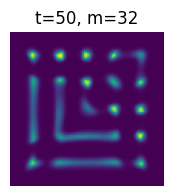

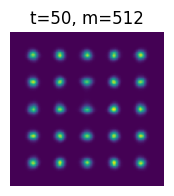

In [5]:
ebm1 = ToyModel().to(device)
optimizer_ebm1 = optim.Adam(ebm1.parameters(), lr=1e-3)
ema_ebm1 = ToyModel(n_output=1).to(device)
ema_ebm1.load_state_dict(ebm1.state_dict())

ebm2 = ToyModel().to(device)
optimizer_ebm2 = optim.Adam(ebm2.parameters(), lr=1e-3)
ema_ebm2 = ToyModel(n_output=1).to(device)
ema_ebm2.load_state_dict(ebm2.state_dict())

ebm3 = ToyModel().to(device)
optimizer_ebm3 = optim.Adam(ebm3.parameters(), lr=1e-3)
ema_ebm3 = ToyModel(n_output=1).to(device)
ema_ebm3.load_state_dict(ebm3.state_dict())

train(ebm1, ema_ebm1, optimizer_ebm1, dataset, compute_mse=False, algo='ed', m_particles=1, t_noise=50, w_stable=1.0)
train(ebm2, ema_ebm2, optimizer_ebm2, dataset, compute_mse=False, algo='ed', m_particles=32, t_noise=50, w_stable=1.0)
train(ebm3, ema_ebm3, optimizer_ebm3, dataset, compute_mse=False, algo='ed', m_particles=512, t_noise=50, w_stable=1.0)

visualize_energynet(ema_ebm1, 't=50, m=1')
visualize_energynet(ema_ebm2, 't=50, m=32')
visualize_energynet(ema_ebm3, 't=50, m=512')

# Qualitatively Understanding the Effect of $w$ and $M$

$t=1, M=1, 32, 512, w=0$

100%|██████████| 50001/50001 [05:42<00:00, 145.90it/s]


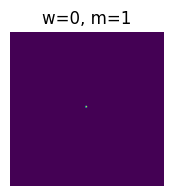

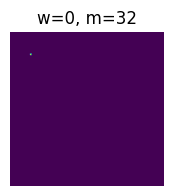

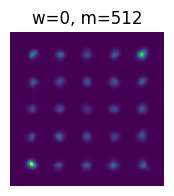

In [6]:
ebm1 = ToyModel().to(device)
optimizer_ebm1 = optim.Adam(ebm1.parameters(), lr=1e-3)
ema_ebm1 = ToyModel(n_output=1).to(device)
ema_ebm1.load_state_dict(ebm1.state_dict())

ebm2 = ToyModel().to(device)
optimizer_ebm2 = optim.Adam(ebm2.parameters(), lr=1e-3)
ema_ebm2 = ToyModel(n_output=1).to(device)
ema_ebm2.load_state_dict(ebm2.state_dict())

ebm3 = ToyModel().to(device)
optimizer_ebm3 = optim.Adam(ebm3.parameters(), lr=1e-3)
ema_ebm3 = ToyModel(n_output=1).to(device)
ema_ebm3.load_state_dict(ebm3.state_dict())

train(ebm1, ema_ebm1, optimizer_ebm1, dataset, compute_mse=False, algo='ed', m_particles=1, t_noise=1, w_stable=0)
train(ebm2, ema_ebm2, optimizer_ebm2, dataset, compute_mse=False, algo='ed', m_particles=32, t_noise=1, w_stable=0)
train(ebm3, ema_ebm3, optimizer_ebm3, dataset, compute_mse=False, algo='ed', m_particles=512, t_noise=1, w_stable=0)

visualize_energynet(ema_ebm1, 'w=0, m=1')
visualize_energynet(ema_ebm2, 'w=0, m=32')
visualize_energynet(ema_ebm3, 'w=0, m=512')

$t=1, M=1, 32, 512, w=0.05$

100%|██████████| 50001/50001 [05:44<00:00, 145.13it/s]


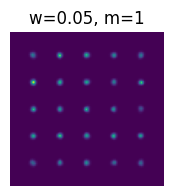

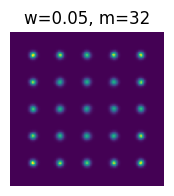

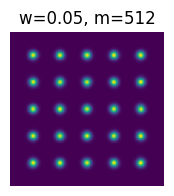

In [7]:
ebm1 = ToyModel().to(device)
optimizer_ebm1 = optim.Adam(ebm1.parameters(), lr=1e-3)
ema_ebm1 = ToyModel(n_output=1).to(device)
ema_ebm1.load_state_dict(ebm1.state_dict())

ebm2 = ToyModel().to(device)
optimizer_ebm2 = optim.Adam(ebm2.parameters(), lr=1e-3)
ema_ebm2 = ToyModel(n_output=1).to(device)
ema_ebm2.load_state_dict(ebm2.state_dict())

ebm3 = ToyModel().to(device)
optimizer_ebm3 = optim.Adam(ebm3.parameters(), lr=1e-3)
ema_ebm3 = ToyModel(n_output=1).to(device)
ema_ebm3.load_state_dict(ebm3.state_dict())

train(ebm1, ema_ebm1, optimizer_ebm1, dataset, compute_mse=False, algo='ed', m_particles=1, t_noise=1, w_stable=0.05)
train(ebm2, ema_ebm2, optimizer_ebm2, dataset, compute_mse=False, algo='ed', m_particles=32, t_noise=1, w_stable=0.05)
train(ebm3, ema_ebm3, optimizer_ebm3, dataset, compute_mse=False, algo='ed', m_particles=512, t_noise=1, w_stable=0.05)

visualize_energynet(ema_ebm1, 'w=0.05, m=1')
visualize_energynet(ema_ebm2, 'w=0.05, m=32')
visualize_energynet(ema_ebm3, 'w=0.05, m=512')

$t=1, M=1, 32, 512, w=50$

100%|██████████| 50001/50001 [05:50<00:00, 142.76it/s]


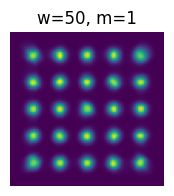

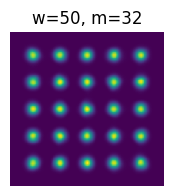

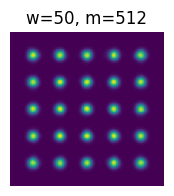

In [8]:
ebm1 = ToyModel().to(device)
optimizer_ebm1 = optim.Adam(ebm1.parameters(), lr=1e-3)
ema_ebm1 = ToyModel(n_output=1).to(device)
ema_ebm1.load_state_dict(ebm1.state_dict())

ebm2 = ToyModel().to(device)
optimizer_ebm2 = optim.Adam(ebm2.parameters(), lr=1e-3)
ema_ebm2 = ToyModel(n_output=1).to(device)
ema_ebm2.load_state_dict(ebm2.state_dict())

ebm3 = ToyModel().to(device)
optimizer_ebm3 = optim.Adam(ebm3.parameters(), lr=1e-3)
ema_ebm3 = ToyModel(n_output=1).to(device)
ema_ebm3.load_state_dict(ebm3.state_dict())

train(ebm1, ema_ebm1, optimizer_ebm1, dataset, compute_mse=False, algo='ed', m_particles=1, t_noise=1, w_stable=50)
train(ebm2, ema_ebm2, optimizer_ebm2, dataset, compute_mse=False, algo='ed', m_particles=32, t_noise=1, w_stable=50)
train(ebm3, ema_ebm3, optimizer_ebm3, dataset, compute_mse=False, algo='ed', m_particles=512, t_noise=1, w_stable=50)

visualize_energynet(ema_ebm1, 'w=50, m=1')
visualize_energynet(ema_ebm2, 'w=50, m=32')
visualize_energynet(ema_ebm3, 'w=50, m=512')